In [207]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [216]:
import scipy as sp

In [251]:
cols =[i for i in range(20)]
rename = {0: "date", 1: "cpu_temp", 5:"fan0", 6:"fan1", 15:"battery_temp", 12: "current_charge", 13: "max_charge"}
uptime_cols = ['load_1m', 'load_5m', 'load_15m']

In [252]:
def read(file):
    df = (pd.read_csv(file, sep="\t", names=cols)
            .rename(columns=rename)
            .assign(date = lambda df: pd.to_datetime(df['date'].str[:-17]))
            .assign(delta_time = lambda df: df['date'] - df['date'].min())
            .assign(delta = lambda df: df['delta_time']/pd.Timedelta('1m'))
            #.set_index("date")
         )
    return df

df_cat = read("raw_catalina.log")
df_cat.head()

,date,cpu_temp,2,3,4,fan0,fan1,7,8,9,...,current_charge,max_charge,14,battery_temp,16,17,18,19,delta_time,delta
0,2023-01-02 21:07:27-03:00,60.31,NaN,--- Fan Stats ---,2,2347,2167,NaN,--- Battery Stats ---,Good,...,7698,7792,8790,35.39,NaN,For more stats run `istats extra` and follow t...,"21:07 up 12 mins, 2 users, load averages: 1.1...",NaN,0 days 00:00:00,0.000000
1,2023-01-02 21:07:37-03:00,59.75,NaN,--- Fan Stats ---,2,2373,2187,NaN,--- Battery Stats ---,Good,...,7698,7792,8790,35.39,NaN,For more stats run `istats extra` and follow t...,"21:07 up 12 mins, 2 users, load averages: 1.3...",NaN,0 days 00:00:10,0.166667
2,2023-01-02 21:07:47-03:00,59.44,NaN,--- Fan Stats ---,2,2372,2187,NaN,--- Battery Stats ---,Good,...,7698,7792,8790,34.59,NaN,For more stats run `istats extra` and follow t...,"21:07 up 12 mins, 2 users, load averages: 1.6...",NaN,0 days 00:00:20,0.333333
3,2023-01-02 21:07:57-03:00,56.94,NaN,--- Fan Stats ---,2,2276,2121,NaN,--- Battery Stats ---,Good,...,7698,7792,8790,34.50,NaN,For more stats run `istats extra` and follow t...,"21:07 up 13 mins, 2 users, load averages: 1.6...",NaN,0 days 00:00:30,0.500000
4,2023-01-02 21:08:08-03:00,55.63,NaN,--- Fan Stats ---,2,2177,2012,NaN,--- Battery Stats ---,Good,...,7698,7792,8790,34.50,NaN,For more stats run `istats extra` and follow t...,"21:08 up 13 mins, 2 users, load averages: 1.9...",NaN,0 days 00:00:41,0.683333


In [253]:
def add_uptime(df):
    df_cat = df.copy()
    uptime = df_cat[18].str.split(expand=True).set_index(df_cat.index)
    null_series = uptime[10].isnull()

    up_cols = dict(zip(uptime.columns[-4:-1], uptime_cols))
    down_cols = dict(zip(uptime.columns[-3:], uptime_cols))

    uptime_up = uptime[null_series].rename(columns = up_cols)
    uptime_down = uptime[~null_series].rename(columns = down_cols)

    uptime_final = pd.concat([uptime_up, uptime_down]).sort_index()[uptime_cols].astype(float)
    assert len(uptime) == len(uptime_final)
    assert len(uptime_final) == len(uptime_final.dropna())
    
    out_frame = df_cat.join(uptime_final)
    return out_frame

uptime_cat = add_uptime(df_cat)
uptime_cat.head()

,date,cpu_temp,2,3,4,fan0,fan1,7,8,9,...,battery_temp,16,17,18,19,delta_time,delta,load_1m,load_5m,load_15m
0,2023-01-02 21:07:27-03:00,60.31,NaN,--- Fan Stats ---,2,2347,2167,NaN,--- Battery Stats ---,Good,...,35.39,NaN,For more stats run `istats extra` and follow t...,"21:07 up 12 mins, 2 users, load averages: 1.1...",NaN,0 days 00:00:00,0.000000,1.19,1.04,0.69
1,2023-01-02 21:07:37-03:00,59.75,NaN,--- Fan Stats ---,2,2373,2187,NaN,--- Battery Stats ---,Good,...,35.39,NaN,For more stats run `istats extra` and follow t...,"21:07 up 12 mins, 2 users, load averages: 1.3...",NaN,0 days 00:00:10,0.166667,1.32,1.07,0.71
2,2023-01-02 21:07:47-03:00,59.44,NaN,--- Fan Stats ---,2,2372,2187,NaN,--- Battery Stats ---,Good,...,34.59,NaN,For more stats run `istats extra` and follow t...,"21:07 up 12 mins, 2 users, load averages: 1.6...",NaN,0 days 00:00:20,0.333333,1.64,1.15,0.74
3,2023-01-02 21:07:57-03:00,56.94,NaN,--- Fan Stats ---,2,2276,2121,NaN,--- Battery Stats ---,Good,...,34.50,NaN,For more stats run `istats extra` and follow t...,"21:07 up 13 mins, 2 users, load averages: 1.6...",NaN,0 days 00:00:30,0.500000,1.62,1.16,0.75
4,2023-01-02 21:08:08-03:00,55.63,NaN,--- Fan Stats ---,2,2177,2012,NaN,--- Battery Stats ---,Good,...,34.50,NaN,For more stats run `istats extra` and follow t...,"21:08 up 13 mins, 2 users, load averages: 1.9...",NaN,0 days 00:00:41,0.683333,1.90,1.23,0.78


In [254]:
uptime_cat

,date,cpu_temp,2,3,4,fan0,fan1,7,8,9,...,battery_temp,16,17,18,19,delta_time,delta,load_1m,load_5m,load_15m
0,2023-01-02 21:07:27-03:00,60.31,NaN,--- Fan Stats ---,2,2347,2167,NaN,--- Battery Stats ---,Good,...,35.39,NaN,For more stats run `istats extra` and follow t...,"21:07 up 12 mins, 2 users, load averages: 1.1...",NaN,0 days 00:00:00,0.000000,1.19,1.04,0.69
1,2023-01-02 21:07:37-03:00,59.75,NaN,--- Fan Stats ---,2,2373,2187,NaN,--- Battery Stats ---,Good,...,35.39,NaN,For more stats run `istats extra` and follow t...,"21:07 up 12 mins, 2 users, load averages: 1.3...",NaN,0 days 00:00:10,0.166667,1.32,1.07,0.71
2,2023-01-02 21:07:47-03:00,59.44,NaN,--- Fan Stats ---,2,2372,2187,NaN,--- Battery Stats ---,Good,...,34.59,NaN,For more stats run `istats extra` and follow t...,"21:07 up 12 mins, 2 users, load averages: 1.6...",NaN,0 days 00:00:20,0.333333,1.64,1.15,0.74
3,2023-01-02 21:07:57-03:00,56.94,NaN,--- Fan Stats ---,2,2276,2121,NaN,--- Battery Stats ---,Good,...,34.50,NaN,For more stats run `istats extra` and follow t...,"21:07 up 13 mins, 2 users, load averages: 1.6...",NaN,0 days 00:00:30,0.500000,1.62,1.16,0.75
4,2023-01-02 21:08:08-03:00,55.63,NaN,--- Fan Stats ---,2,2177,2012,NaN,--- Battery Stats ---,Good,...,34.50,NaN,For more stats run `istats extra` and follow t...,"21:08 up 13 mins, 2 users, load averages: 1.9...",NaN,0 days 00:00:41,0.683333,1.90,1.23,0.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1809,2023-01-03 02:14:25-03:00,38.50,NaN,--- Fan Stats ---,2,1814,1695,NaN,--- Battery Stats ---,Good,...,30.19,NaN,For more stats run `istats extra` and follow t...,"2:14 up 5:19, 3 users, load averages: 1.73 ...",NaN,0 days 05:06:58,306.966667,1.73,1.93,1.95
1810,2023-01-03 02:14:35-03:00,39.25,NaN,--- Fan Stats ---,2,1827,1707,NaN,--- Battery Stats ---,Good,...,30.19,NaN,For more stats run `istats extra` and follow t...,"2:14 up 5:19, 3 users, load averages: 1.61 ...",NaN,0 days 05:07:08,307.133333,1.61,1.90,1.93
1811,2023-01-03 02:14:45-03:00,37.94,NaN,--- Fan Stats ---,2,1827,1714,NaN,--- Battery Stats ---,Good,...,30.19,NaN,For more stats run `istats extra` and follow t...,"2:14 up 5:19, 3 users, load averages: 1.66 ...",NaN,0 days 05:07:18,307.300000,1.66,1.90,1.93
1812,2023-01-03 09:02:29-03:00,29.00,NaN,--- Fan Stats ---,2,1702,1607,NaN,--- Battery Stats ---,Good,...,29.39,NaN,For more stats run `istats extra` and follow t...,"9:02 up 12:07, 3 users, load averages: 1.99 ...",NaN,0 days 11:55:02,715.033333,1.99,1.96,1.95


In [255]:
uptime_mon = add_uptime(read("raw_monterey.log"))
uptime_mon.head()

,date,cpu_temp,2,3,4,fan0,fan1,7,8,9,...,battery_temp,16,17,18,19,delta_time,delta,load_1m,load_5m,load_15m
0,2023-01-01 18:38:25-03:00,54.00,NaN,--- Fan Stats ---,2,1846,1699,NaN,--- Battery Stats ---,Good,...,30.30,NaN,For more stats run `istats extra` and follow t...,"18:38 up 1:34, 2 users, load averages: 2.87 ...",NaN,0 days 00:00:00,0.000000,2.87,1.78,1.45
1,2023-01-01 18:38:35-03:00,52.94,NaN,--- Fan Stats ---,2,1846,1701,NaN,--- Battery Stats ---,Good,...,29.59,NaN,For more stats run `istats extra` and follow t...,"18:38 up 1:34, 2 users, load averages: 2.81 ...",NaN,0 days 00:00:10,0.166667,2.81,1.80,1.46
2,2023-01-01 18:38:45-03:00,53.31,NaN,--- Fan Stats ---,2,1835,1689,NaN,--- Battery Stats ---,Good,...,29.80,NaN,For more stats run `istats extra` and follow t...,"18:38 up 1:34, 2 users, load averages: 2.67 ...",NaN,0 days 00:00:20,0.333333,2.67,1.81,1.46
3,2023-01-01 18:38:56-03:00,53.00,NaN,--- Fan Stats ---,2,1846,1717,NaN,--- Battery Stats ---,Good,...,29.80,NaN,For more stats run `istats extra` and follow t...,"18:38 up 1:34, 2 users, load averages: 2.50 ...",NaN,0 days 00:00:31,0.516667,2.50,1.80,1.46
4,2023-01-01 18:39:06-03:00,52.13,NaN,--- Fan Stats ---,2,1835,1698,NaN,--- Battery Stats ---,Good,...,29.80,NaN,For more stats run `istats extra` and follow t...,"18:39 up 1:35, 2 users, load averages: 2.26 ...",NaN,0 days 00:00:41,0.683333,2.26,1.77,1.46


In [256]:
final = pd.concat([uptime_mon.assign(macos="monterey"), uptime_cat.assign(macos="catalina")])
final = final[final['delta_time'] < pd.Timedelta("10h")]
final

,date,cpu_temp,2,3,4,fan0,fan1,7,8,9,...,16,17,18,19,delta_time,delta,load_1m,load_5m,load_15m,macos
0,2023-01-01 18:38:25-03:00,54.00,NaN,--- Fan Stats ---,2,1846,1699,NaN,--- Battery Stats ---,Good,...,NaN,For more stats run `istats extra` and follow t...,"18:38 up 1:34, 2 users, load averages: 2.87 ...",NaN,0 days 00:00:00,0.000000,2.87,1.78,1.45,monterey
1,2023-01-01 18:38:35-03:00,52.94,NaN,--- Fan Stats ---,2,1846,1701,NaN,--- Battery Stats ---,Good,...,NaN,For more stats run `istats extra` and follow t...,"18:38 up 1:34, 2 users, load averages: 2.81 ...",NaN,0 days 00:00:10,0.166667,2.81,1.80,1.46,monterey
2,2023-01-01 18:38:45-03:00,53.31,NaN,--- Fan Stats ---,2,1835,1689,NaN,--- Battery Stats ---,Good,...,NaN,For more stats run `istats extra` and follow t...,"18:38 up 1:34, 2 users, load averages: 2.67 ...",NaN,0 days 00:00:20,0.333333,2.67,1.81,1.46,monterey
3,2023-01-01 18:38:56-03:00,53.00,NaN,--- Fan Stats ---,2,1846,1717,NaN,--- Battery Stats ---,Good,...,NaN,For more stats run `istats extra` and follow t...,"18:38 up 1:34, 2 users, load averages: 2.50 ...",NaN,0 days 00:00:31,0.516667,2.50,1.80,1.46,monterey
4,2023-01-01 18:39:06-03:00,52.13,NaN,--- Fan Stats ---,2,1835,1698,NaN,--- Battery Stats ---,Good,...,NaN,For more stats run `istats extra` and follow t...,"18:39 up 1:35, 2 users, load averages: 2.26 ...",NaN,0 days 00:00:41,0.683333,2.26,1.77,1.46,monterey
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1807,2023-01-03 02:14:04-03:00,39.31,NaN,--- Fan Stats ---,2,1823,1707,NaN,--- Battery Stats ---,Good,...,NaN,For more stats run `istats extra` and follow t...,"2:14 up 5:19, 3 users, load averages: 1.70 ...",NaN,0 days 05:06:37,306.616667,1.70,1.95,1.95,catalina
1808,2023-01-03 02:14:14-03:00,38.50,NaN,--- Fan Stats ---,2,1846,1686,NaN,--- Battery Stats ---,Good,...,NaN,For more stats run `istats extra` and follow t...,"2:14 up 5:19, 3 users, load averages: 1.60 ...",NaN,0 days 05:06:47,306.783333,1.60,1.91,1.94,catalina
1809,2023-01-03 02:14:25-03:00,38.50,NaN,--- Fan Stats ---,2,1814,1695,NaN,--- Battery Stats ---,Good,...,NaN,For more stats run `istats extra` and follow t...,"2:14 up 5:19, 3 users, load averages: 1.73 ...",NaN,0 days 05:06:58,306.966667,1.73,1.93,1.95,catalina
1810,2023-01-03 02:14:35-03:00,39.25,NaN,--- Fan Stats ---,2,1827,1707,NaN,--- Battery Stats ---,Good,...,NaN,For more stats run `istats extra` and follow t...,"2:14 up 5:19, 3 users, load averages: 1.61 ...",NaN,0 days 05:07:08,307.133333,1.61,1.90,1.93,catalina


In [257]:
selected_cols = [x for x in final.columns if isinstance(x, str)]
selected_cols

['date',
 'cpu_temp',
 'fan0',
 'fan1',
 'current_charge',
 'max_charge',
 'battery_temp',
 'delta_time',
 'delta',
 'load_1m',
 'load_5m',
 'load_15m',
 'macos']

In [258]:
df = final[selected_cols]
df

,date,cpu_temp,fan0,fan1,current_charge,max_charge,battery_temp,delta_time,delta,load_1m,load_5m,load_15m,macos
0,2023-01-01 18:38:25-03:00,54.00,1846,1699,7802,7833,30.30,0 days 00:00:00,0.000000,2.87,1.78,1.45,monterey
1,2023-01-01 18:38:35-03:00,52.94,1846,1701,7802,7833,29.59,0 days 00:00:10,0.166667,2.81,1.80,1.46,monterey
2,2023-01-01 18:38:45-03:00,53.31,1835,1689,7802,7833,29.80,0 days 00:00:20,0.333333,2.67,1.81,1.46,monterey
3,2023-01-01 18:38:56-03:00,53.00,1846,1717,7802,7833,29.80,0 days 00:00:31,0.516667,2.50,1.80,1.46,monterey
4,2023-01-01 18:39:06-03:00,52.13,1835,1698,7802,7833,29.80,0 days 00:00:41,0.683333,2.26,1.77,1.46,monterey
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1807,2023-01-03 02:14:04-03:00,39.31,1823,1707,27,7805,30.19,0 days 05:06:37,306.616667,1.70,1.95,1.95,catalina
1808,2023-01-03 02:14:14-03:00,38.50,1846,1686,27,7805,30.19,0 days 05:06:47,306.783333,1.60,1.91,1.94,catalina
1809,2023-01-03 02:14:25-03:00,38.50,1814,1695,4,7809,30.19,0 days 05:06:58,306.966667,1.73,1.93,1.95,catalina
1810,2023-01-03 02:14:35-03:00,39.25,1827,1707,4,7809,30.19,0 days 05:07:08,307.133333,1.61,1.90,1.93,catalina


In [259]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3625 entries, 0 to 1811
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype                                 
---  ------          --------------  -----                                 
 0   date            3625 non-null   datetime64[ns, pytz.FixedOffset(-180)]
 1   cpu_temp        3625 non-null   float64                               
 2   fan0            3625 non-null   int64                                 
 3   fan1            3625 non-null   int64                                 
 4   current_charge  3625 non-null   int64                                 
 5   max_charge      3625 non-null   int64                                 
 6   battery_temp    3625 non-null   float64                               
 7   delta_time      3625 non-null   timedelta64[ns]                       
 8   delta           3625 non-null   float64                               
 9   load_1m         3625 non-null   float64             

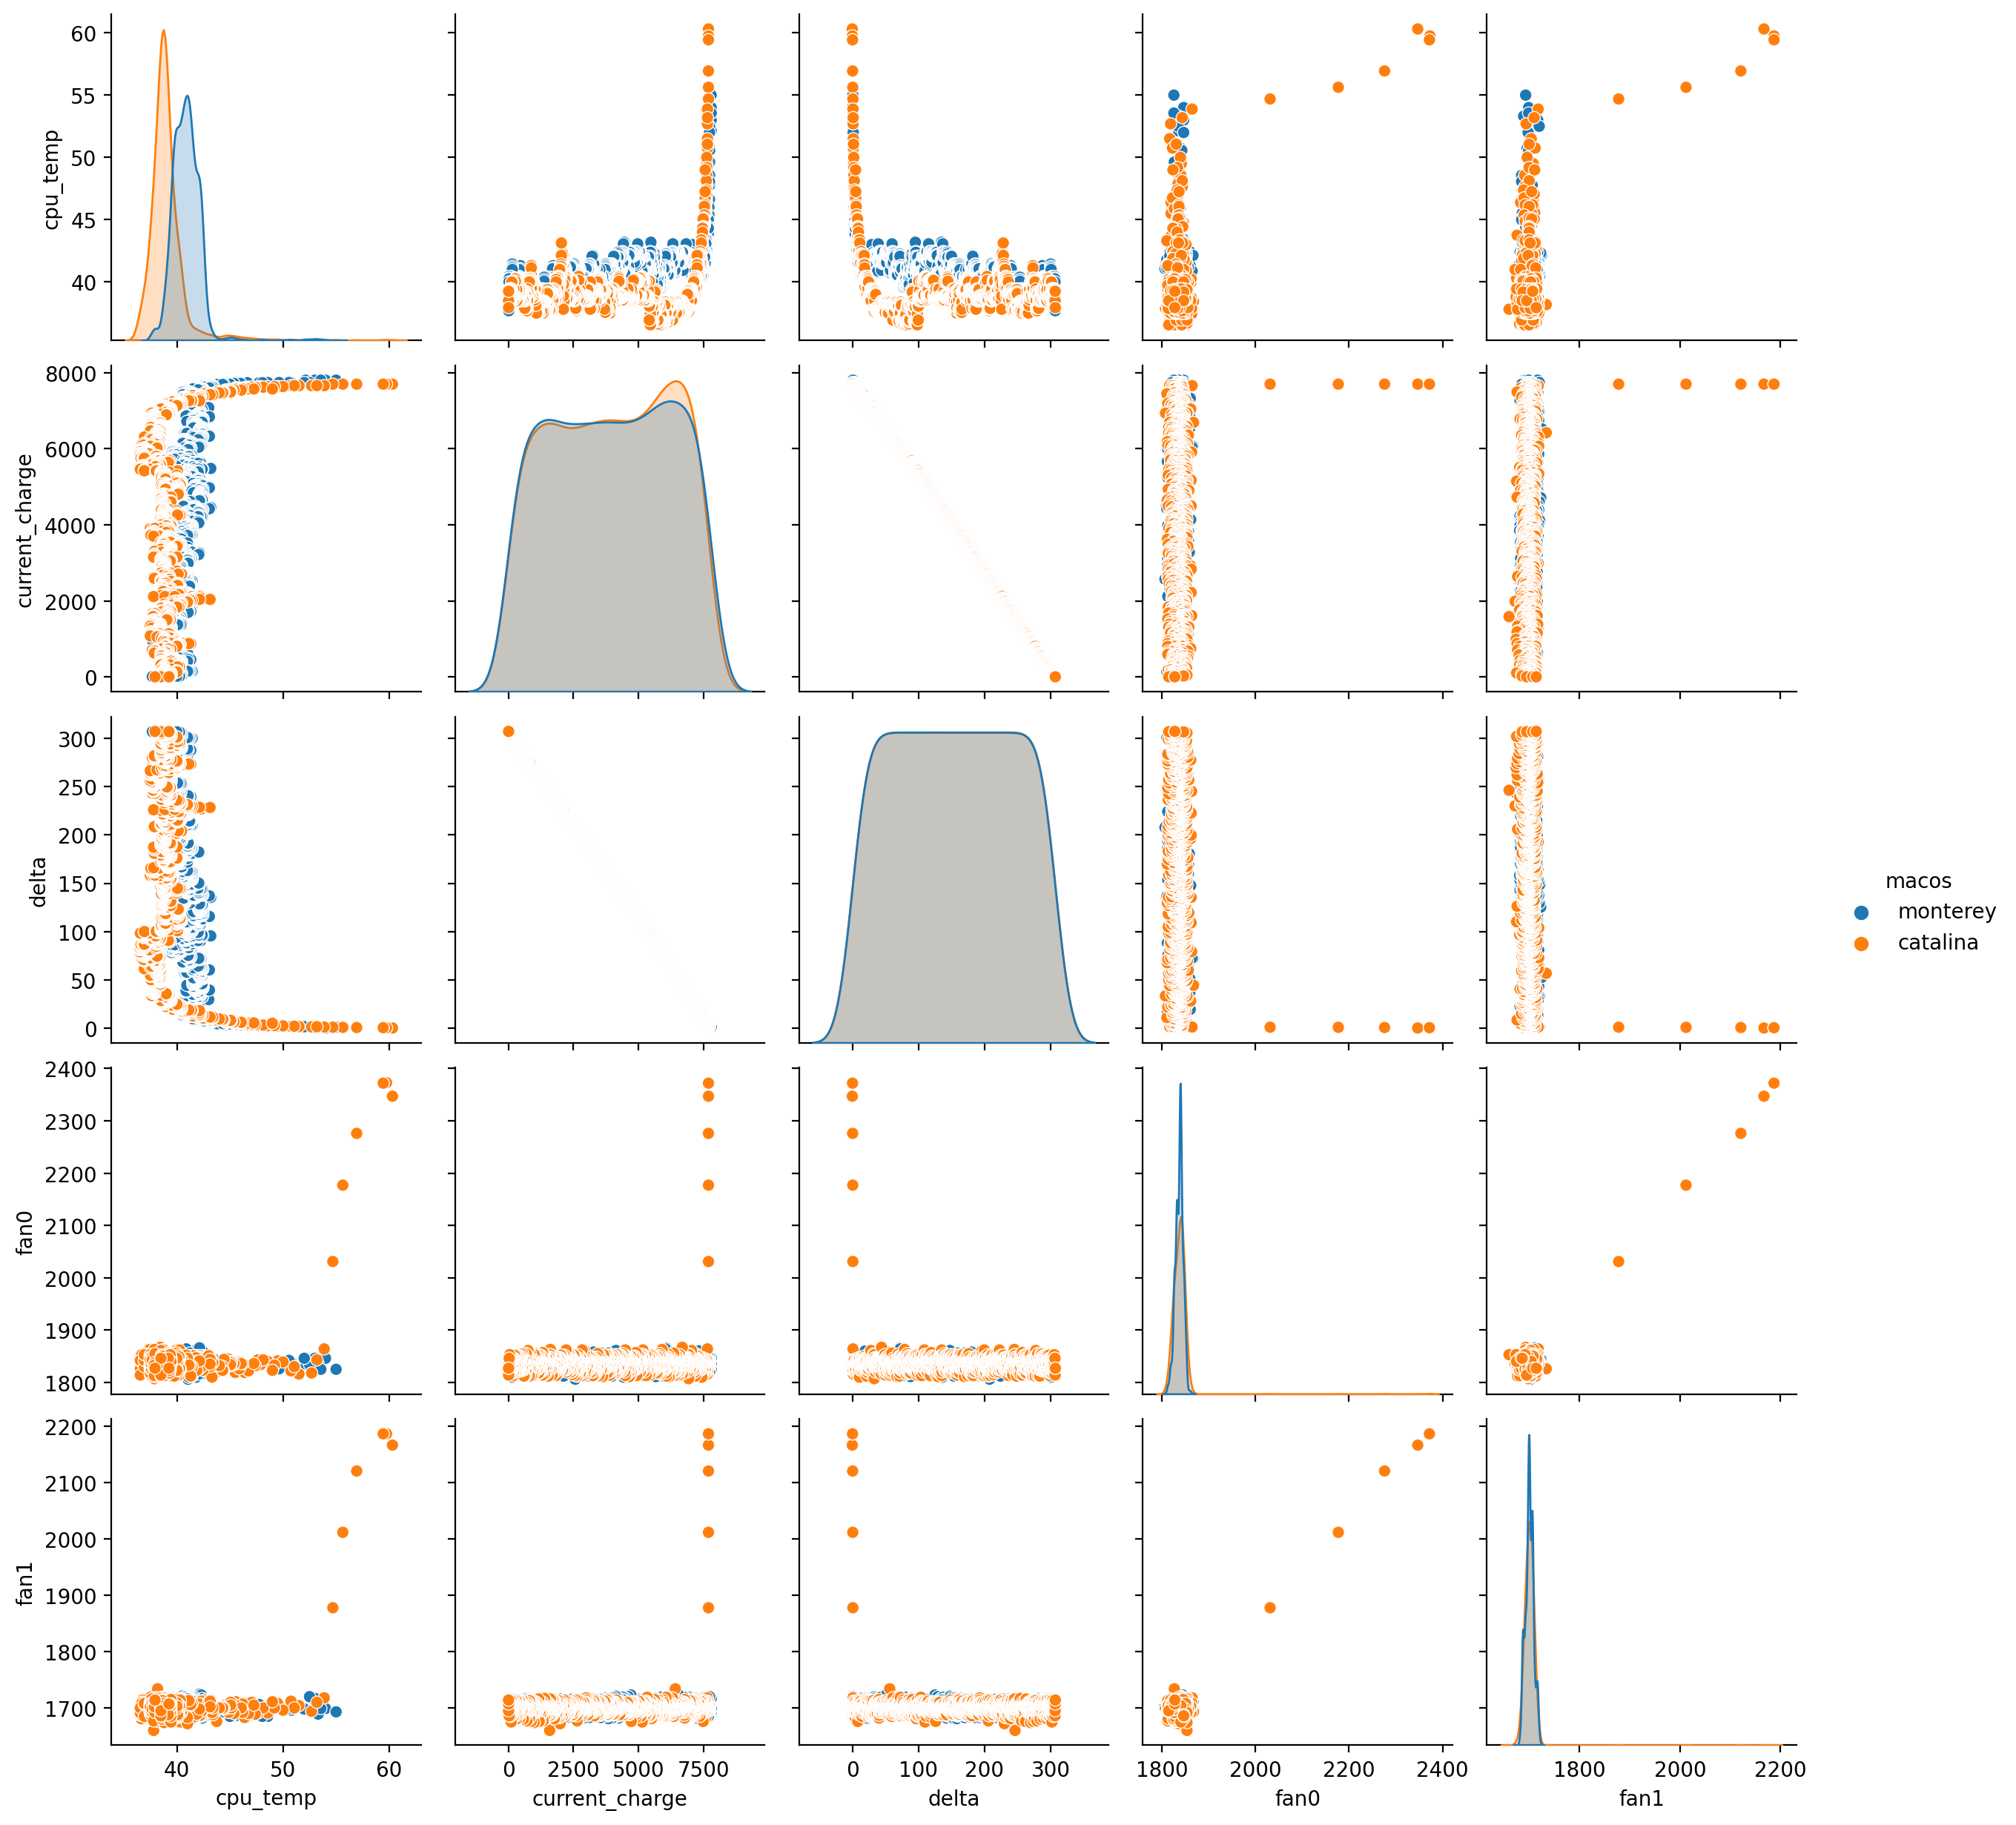

In [260]:
sns.pairplot(df[['cpu_temp','current_charge','delta','macos','fan0','fan1']], hue="macos")

<AxesSubplot: xlabel='delta', ylabel='cpu_temp'>

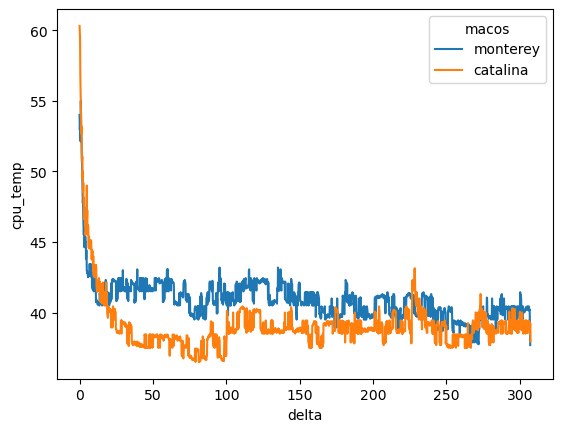

In [185]:
sns.lineplot(data=df, x="delta", y="cpu_temp", hue="macos")

<AxesSubplot: xlabel='delta', ylabel='battery_temp'>

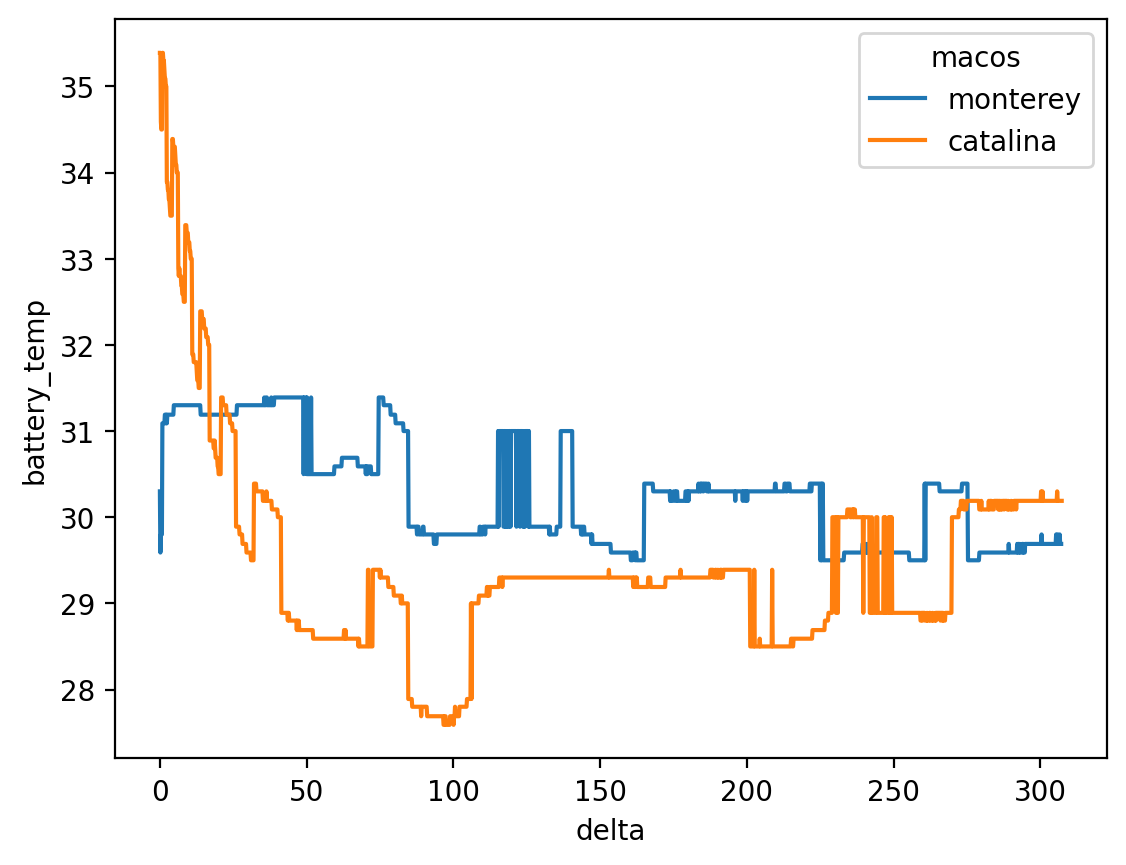

In [231]:
sns.lineplot(data=df, x="delta", y="battery_temp", hue="macos")

<AxesSubplot: xlabel='delta', ylabel='fan0'>

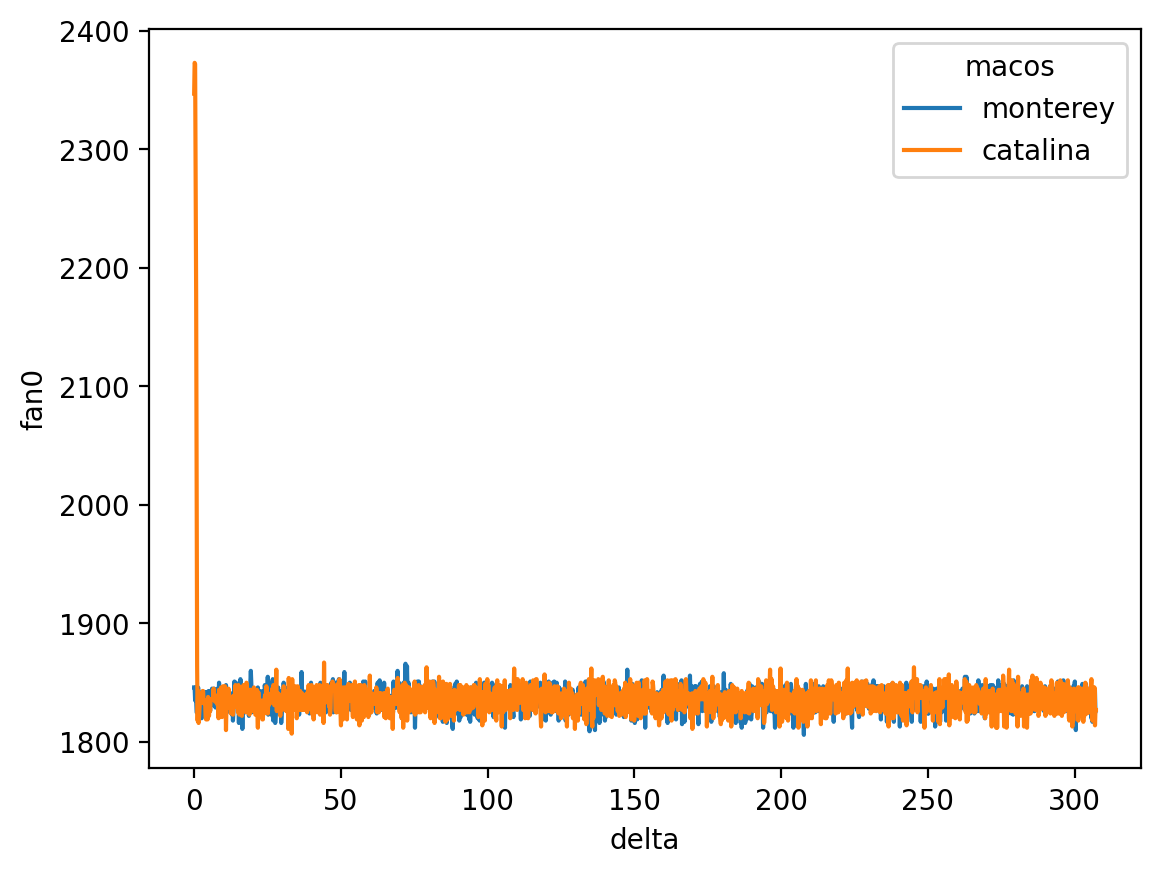

In [261]:
sns.lineplot(data=df, x="delta", y="fan0", hue="macos")

<AxesSubplot: xlabel='delta', ylabel='fan1'>

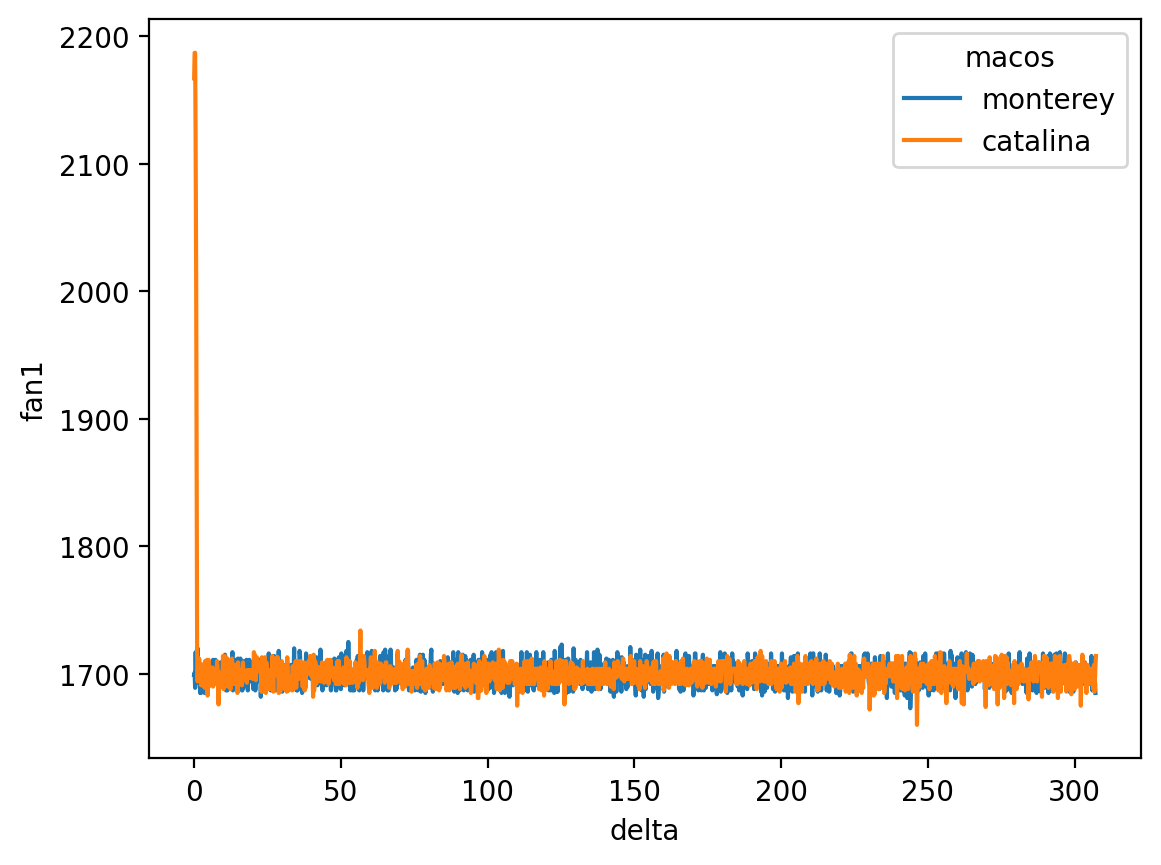

In [262]:
sns.lineplot(data=df, x="delta", y="fan1", hue="macos")

In [232]:
df.columns

Index(['date', 'cpu_temp', 'current_charge', 'max_charge', 'battery_temp',
       'delta_time', 'delta', 'load_1m', 'load_5m', 'load_15m', 'macos'],
      dtype='object')

In [ ]:
sns.lineplot(data=df, x="delta", y="battery_temp", hue="macos")

<AxesSubplot: xlabel='delta', ylabel='current_charge'>

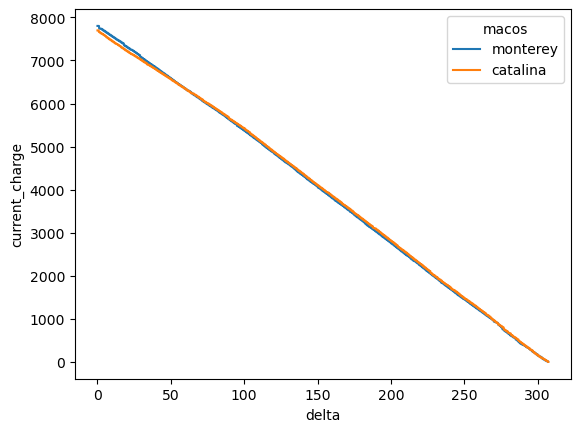

In [186]:
sns.lineplot(data=df, x="delta", y="current_charge", hue="macos")

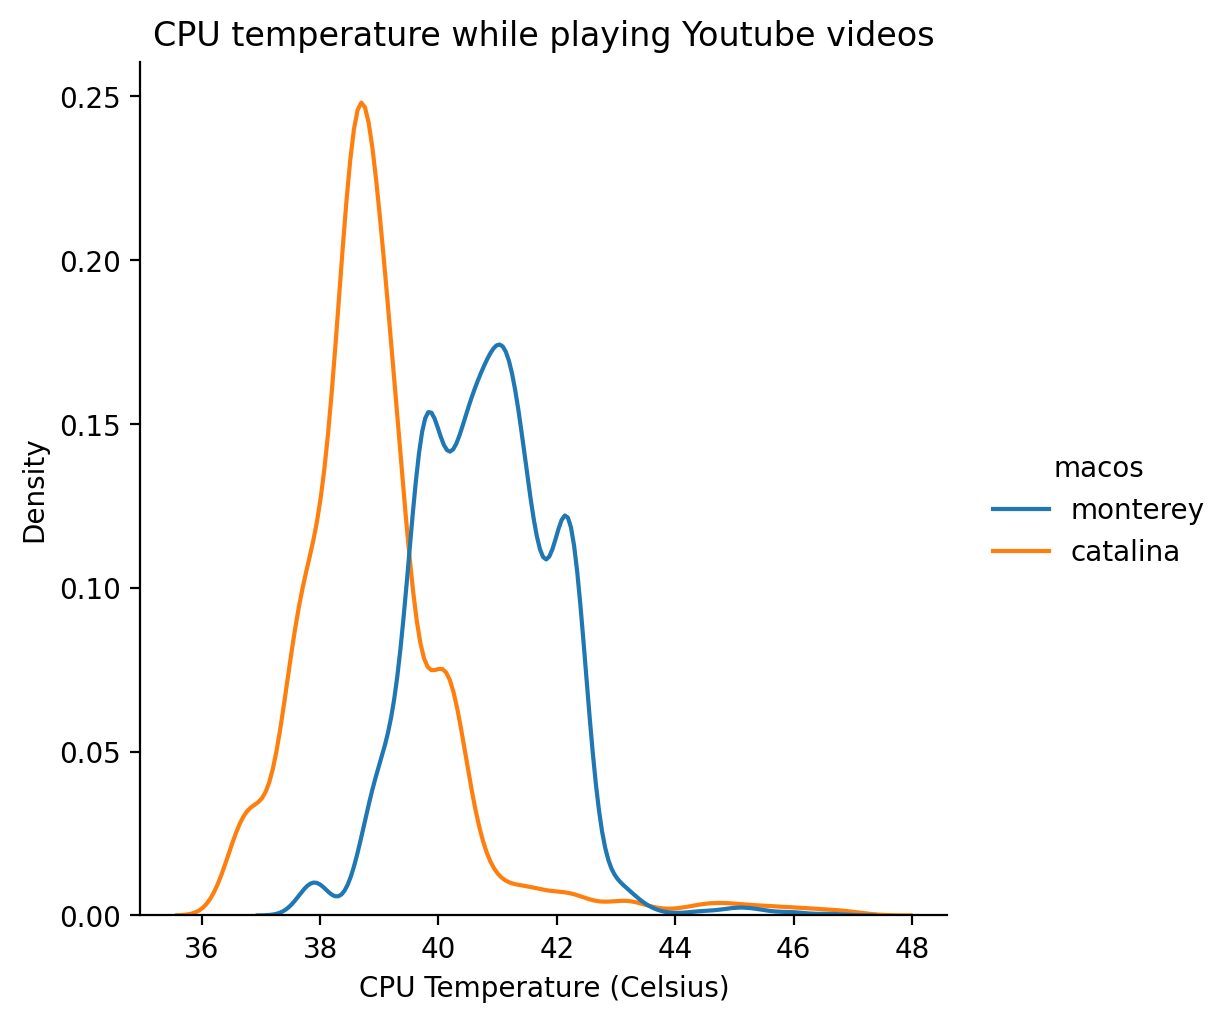

In [219]:
cutout = df['cpu_temp'].quantile(0.99)
sns.displot(data=df[df['cpu_temp'] < cutout], x="cpu_temp", hue="macos", kind="kde")
plt.title("CPU temperature while playing Youtube videos")
plt.xlabel("CPU Temperature (Celsius)");

In [223]:
# Test Kolmogorov–Smirnov
x = df[df['macos'] == 'catalina']['cpu_temp']
y = df[df['macos'] == 'monterey']['cpu_temp']
sp.stats.ks_2samp(x, y)

KstestResult(statistic=0.7174849535303651, pvalue=0.0)

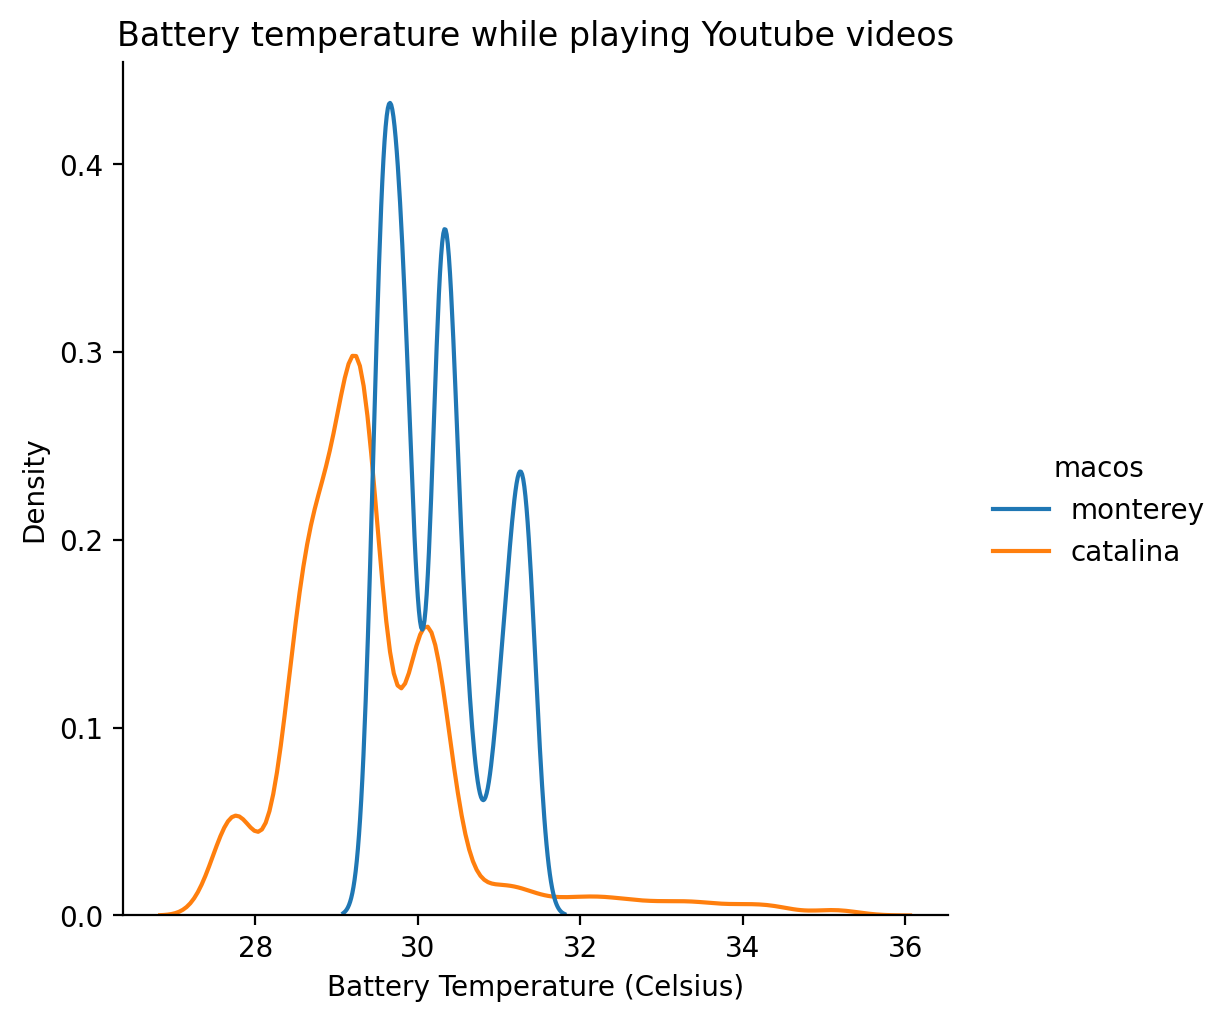

In [229]:
cutout = df['battery_temp'].max()
sns.displot(data=df[df['battery_temp'] < cutout], x="battery_temp", hue="macos", kind="kde")
plt.title("Battery temperature while playing Youtube videos")
plt.xlabel("Battery Temperature (Celsius)");

In [230]:
# Test Kolmogorov–Smirnov
x = df[df['macos'] == 'catalina']['battery_temp']
y = df[df['macos'] == 'monterey']['battery_temp']
sp.stats.ks_2samp(x, y)

KstestResult(statistic=0.6970198675496688, pvalue=0.0)

In [264]:
df[df['macos'] == 'catalina']['delta_time'].max()

Timedelta('0 days 05:07:18')

In [265]:
df[df['macos'] == 'monterey']['delta_time'].max()

Timedelta('0 days 05:07:07')

In [266]:
df.describe()

,cpu_temp,fan0,fan1,current_charge,max_charge,battery_temp,delta_time,delta,load_1m,load_5m,load_15m
count,3625.000000,3625.000000,3625.000000,3625.000000,3625.000000,3625.000000,3625,3625.000000,3625.000000,3625.000000,3625.000000
mean,40.000957,1836.687724,1700.679448,3957.331310,7793.810207,29.857217,0 days 02:33:33.874758620,153.564579,1.794825,1.776841,1.722695
std,1.989923,20.207358,18.291344,2262.985721,15.657670,1.020991,0 days 01:28:43.445537218,88.724092,0.393561,0.216549,0.178558
min,36.500000,1806.000000,1660.000000,4.000000,7750.000000,27.590000,0 days 00:00:00,0.000000,0.720000,1.040000,0.690000
25%,38.750000,1830.000000,1695.000000,1988.000000,7782.000000,29.300000,0 days 01:16:46,76.766667,1.520000,1.610000,1.590000
50%,39.810000,1838.000000,1700.000000,3996.000000,7795.000000,29.800000,0 days 02:33:32,153.533333,1.770000,1.770000,1.710000
75%,41.000000,1842.000000,1705.000000,5957.000000,7804.000000,30.300000,0 days 03:50:22,230.366667,2.030000,1.930000,1.870000
max,60.310000,2373.000000,2187.000000,7802.000000,7850.000000,35.390000,0 days 05:07:18,307.300000,3.490000,2.400000,2.130000
